# Project 2 - Source coding, data compression and channel coding

The goal of this second project is to apply some of the principles seen in the lectures about source coding, data compression and channel coding. We ask you to write a brief report (pdf format) collecting your answers to the different questions. All codes must be written in Python inside this Jupyter. Note that you can not change the content of locked cells or import any extra Python library than the ones already imported (numpy).

## Implementation

In this project, you will need to use implement source coding algorithms to answer several questions. Therefore, in this first part, you are asked to write several functions that implement two of the  algorithms seen in the theoretical lectures and one new algorithm described in the project statement. Remember that you need to fill in this Jupyter Notebook to answer these questions. Pay particular attention to the required input and output format of each function.

In [1]:
# [Locked Cell] You can not import any extra Python library in this Notebook.
import numpy as np

### Question 1
Implement a function that returns a binary Huffman code for a given probability distribution. Give the main steps of your implementation. Verify your code on Exercise 7 of the second exercise session (TP2), and report the output of your code for this example. Explain how to extend your function to generate a Huffman code of any (output) alphabet size. 


In [6]:
class Node:
    def __init__(self, symbol, prob):
        self.symbol = symbol
        self.prob = prob
        self.left = None
        self.right = None
        self.code = ''

def Huffman_code(probability_dict):
    """
    Create the Huffman code for given probabilities.
    
    Arguments:
    ----------
    probability_dict: A dictionary where keys are symbols (characters or strings)
                      and values are the probability of the symbol as a float or double.
    
    Returns:
    ----------    
    codewords: A dictionary with the name and the corresponding codeword.
               Keys are symbols (characters or strings) and values are associated
               codeword as a character or a string.
    """
    nodes = [Node(symbol, prob) for symbol, prob in probability_dict.items()]
    while len(nodes) > 1:

        nodes.sort(key=lambda node: node.prob)
        
        # Nodes with fewer probs
        left = nodes.pop(0)
        right = nodes.pop(0)

        new_node = Node(None, left.prob + right.prob)
        new_node.left = left
        new_node.right = right

        nodes.append(new_node)

    root = nodes[0]
    codeword_dict = assign_codes(root)

    return codeword_dict

# Recursive function to assign codes to leaves
def assign_codes(node, prefix=''):
    if node.symbol is not None:
        return {node.symbol: prefix}        
    else:
        codes = {}            
        codes.update(assign_codes(node.left, prefix + '0'))
        codes.update(assign_codes(node.right, prefix + '1'))
        return codes    

probability_dict = {"A": 0.05, "B": 0.10, "C": 0.15, "D": 0.15, "E": 0.2, "F": 0.35} 
Huffman_code(probability_dict)
 

{'A': '000', 'B': '001', 'E': '01', 'C': '100', 'D': '101', 'F': '11'}

### Question 2

Given a sequence of symbols, implement a function that returns a dictionary and the encoded sequence using the on-line Lempel-Ziv algorithm (see State of the art in data compression, slide 50/53). Reproduce and report the example given in the course. 

In [7]:
def LZ_online(sequence):
    """
    The on-line Lempel-Ziv algorithm given a sequence of symbols.
    
    Arguments:
    ----------    
    - sequence: Sequence of symbols in the string format

    Return:
    ----------
    - dictionary: the computed dictionary in the form:
      keys: symbol as character or string
      values: associated codeword as a tuple (integer) and a binarized address with one appended symbol (character or string)
      Example: {'0': (0, ''), '1': (1, '0'), '10': (2, '01'), '00': (3, '010')}
    
    - encoded_sequence: the encoded sequence in the string format
    """
    dictionary = {'': (0, '0')}
    encoded_sequence = ""
    w = ""
    # The first entry is special, handle it separately
    if sequence[0] == '1':
        dictionary['1'] = (1, '1')
        encoded_sequence += "1"
        index = 2  
    else:
        dictionary['0'] = (1, '0')
        encoded_sequence += "0"
        index = 2 
        
    for c in sequence[1:]:
        wc = w + c
        if wc not in dictionary:
            address_bits = int(np.ceil(np.log2(len(dictionary))))
            prefix = format(dictionary[w][0], '0{}b'.format(address_bits)) 
            encoded_sequence += prefix
            
            bin_address = format(index, '0{}b'.format(address_bits))
            dictionary[wc] = (index, bin_address) 
            
            index += 1
            w = ""
        else:
            w = wc
            
    # Encode the last phrase if it's not empty
    if w:
        address_bits = int(np.ceil(np.log2(max(len(dictionary), 1))))
        prefix = format(dictionary[w][0], '0{}b'.format(address_bits))
        encoded_sequence += prefix
    
    return dictionary, encoded_sequence

sequence = "1011010100010"
dictionary, encoded_sequence = LZ_online(sequence)
print(f'dictionary: {dictionary}')
print(f'encoded sequence: {encoded_sequence}')


dictionary: {'': (0, '0'), '1': (1, '1'), '0': (2, '10'), '11': (3, '11'), '01': (4, '100'), '010': (5, '101'), '00': (6, '110'), '10': (7, '111')}
encoded sequence: 100110100010001


### Question 4

Implement a function that returns the encoded sequence using the LZ77 algorithm as described by the algorithm below given an input string and a sliding window size l. Reproduce the example given in Figure 2 with window_size=7.

In [8]:
def LZ77(sequence, window_size=7):
    """
    The Lempel-Ziv 77 algorithm given a sequence of symbols and the sliding window size.
    
    Arguments:
    ----------
    - sequence : Sequence of symbols in the string format
    - window_size : sliding window size as an integer
    
    Return:
    -------
    - encoded_sequence : the encoded sequence in the string format
    """
    encoded_sequence = []
    cursor = 0

    while cursor < len(sequence):
        # Look-ahead buffer
        buffer = sequence[cursor:]
        window = sequence[max(0, cursor-window_size):cursor]

        p = 0
        d = 0
        c = ''
        
        for length in range(1, len(buffer)+1):
            prefix = buffer[:length]
            position = window.rfind(prefix)
            if  position>= 0:
                d = len(window) - position
                p = length
                c = buffer[length] if length < len(buffer) else ''
            else:
                break
             
        # If no match found, just take the first character of the buffer
        if p == 0 and len(buffer) > 0:
            c = buffer[0]
        
        encoded_sequence.append((d, p, c))
        shift = p + 1 if p > 0 else 1
        cursor += shift
    
    encoded_sequence_str = ''.join(['{}{}{}'.format(d, p, c) for d, p, c in encoded_sequence])
    
    return encoded_sequence_str

test_sequence = "abracadabrad"
test_window_size = 7
encoded_result = LZ77(test_sequence, test_window_size)
print(f'Encoded result: {encoded_result}')

Encoded result: 00a00b00r31c21d74d


In [9]:
# [Locked Cell] Evaluation of your functions by the examiner. 
# You don't have access to the evaluation, this will be done by the examiner.
# Therefore, this cell will return nothing for the students.
import os
if os.path.isfile("private_evaluation.py"):
    from private_evaluation import unit_tests
    unit_tests(Huffman_code, LZ_online, LZ77)

## Source coding and reversible (lossless) data compression


In [10]:
# Write here your codes for questions 5 to 15 (you may delete this comment)

## Channel coding

## 16. 
Give the plot of the audio signal and listen to it.

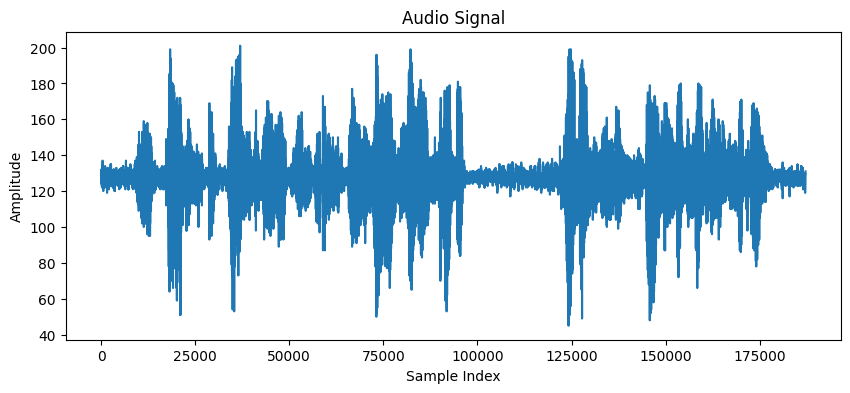

In [11]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
file_path = "./why.wav"
sampling_rate, audio_signal = wavfile.read(file_path)
plt.figure(figsize=(10, 4))
plt.plot(audio_signal)
plt.title('Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

## 17. 
Encode the audio signal using the binary ASCII fixed-length binary code. What is the appropriate number of bits? Justify.

In [12]:
# Given that the audio signal is quantized in a range 0-255 (8 bits) the appropiate number of bits to represent the audio is 8 bits
quantized_signal = np.interp(audio_signal, (audio_signal.min(), audio_signal.max()), (0, 255))
quantized_signal_int = np.round(quantized_signal).astype(np.uint8)
binary_ascii_encoded = [format(sample,
                               '08b') for sample in quantized_signal_int]
print(binary_ascii_encoded[:10])

['10001001', '10001001', '10001011', '10001101', '10001101', '10001101', '10001101', '10001011', '10001011', '10001011']


## 18. 
Simulate the channel effect on the binary audio signal. Then decode the audio signal.
Plot and play the decoded audio signal. What do you notice?

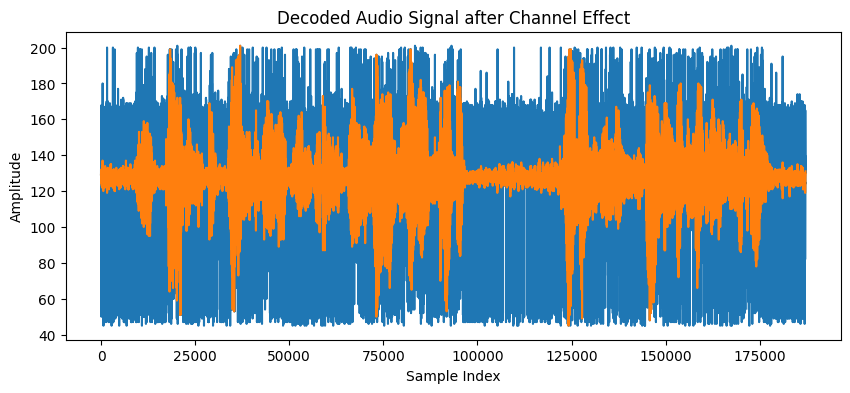

In [14]:
p_error = 0.01
fs = 16000

def simulate_bsc(encoded_signal, p_error):
    """
    Simulates the process of a binary symmetric channel with probability p_error of error
    
    Arguments:
    ----------
    encoded_signal:A string containing the message
    p_error: number between 0 and 1 representing the probability of error
    
    Returns:
    ----------    
   A string representing the message after passing through the binary symmetric channel
    """
    channel_output = []
    for bit_string in encoded_signal:
        flipped_bits = ''.join(['1' if (bit == '0' and np.random.rand() < p_error) else '0' if (bit == '1' and np.random.rand() < p_error) else bit for bit in bit_string])
        channel_output.append(flipped_bits)
    return channel_output

channel_affected_signal = simulate_bsc(binary_ascii_encoded, p_error)
channel_affected_signal_int = np.array([int(bits, 2) for bits in channel_affected_signal], dtype=np.uint8)
decoded_audio_signal_interp = np.interp(channel_affected_signal_int, (0, 255), (audio_signal.min(), audio_signal.max()))
decoded_audio_signal = np.round(decoded_audio_signal_interp).astype(np.uint8)

plt.figure(figsize=(10, 4))
plt.plot(decoded_audio_signal)
plt.plot(audio_signal)
plt.title('Decoded Audio Signal after Channel Effect')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

wavfile.write('decoded_audio.wav', fs,decoded_audio_signal.astype(np.float32))

## 19. 
Instead of sending directly through the channel the binary audio signal, you will first
introduce some redundancy. To do that, implement a function that returns the
Hamming (7,4) code for a given sequence of binary symbols. Then, using your
function, encode the binary audio signal (from question 16).

In [15]:
def hamming_7_4(binary_sequence):
    """
    Encodes a sequence of 4-bit binary symbols using the Hamming (7,4) code.
    
    Arguments:
    ----------
    binary_sequence: A list of strings, where each string is a 4-bit binary symbol.
    
    Returns:
    ----------    
    A list of strings, where each string is a 7-bit encoded binary symbol using the Hamming (7,4) code.
    """
    G= np.array([[1, 1, 0, 1],
                            [1, 0, 1, 1],
                            [1, 0, 0, 0],
                            [0, 1, 1, 1],
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]) # We decided to implement this generator matrix
    
    encoded_sequence = []
    for symbol in binary_sequence:
        symbol_bits = np.array(list(symbol), dtype=int)
        encoded_symbol = np.dot(G, symbol_bits) % 2
        encoded_sequence.append(''.join(str(bit) for bit in encoded_symbol))
    return encoded_sequence

def encode_hamming74(binary_sequence_8bit):
    """
    Encodes 8-bit binary sequences using Hamming (7,4) code by splitting each 8-bit sequence
    into two 4-bit sequences, encoding each with Hamming (7,4), and then concatenating the results.
    
    Arguments:
    ----------
    binary_sequence_8bit: A list of strings, where each string is an 8-bit binary sequence.
    
    Returns:
    ----------
    A list of strings, where each string is a 14-bit sequence resulting from encoding the original 8 bits.
    """
    encoded_sequences = []
    
    for sequence in binary_sequence_8bit:
        first_half, second_half = sequence[:4], sequence[4:]
        
        encoded_first_half = hamming_7_4([first_half])[0]
        encoded_second_half = hamming_7_4([second_half])[0]
        
        encoded_sequence = encoded_first_half + encoded_second_half
        encoded_sequences.append(encoded_sequence)
    
    return encoded_sequences

encoded_sample_red = encode_hamming74(binary_ascii_encoded)


In [16]:
print(encoded_sample_red[:10])

['11100000011001', '11100000011001', '11100000110011', '11100001010101', '11100001010101', '11100001010101', '11100001010101', '11100000110011', '11100000110011', '11100000110011']


## 20. 
Simulate the channel effect on the binary audio signal with redundancy. Then decode
the binary audio signal. Listen to it and display the decoded audio signal. What do
you notice? Explain your decoding procedure.

In [17]:
def hamming_7_4_decode(encoded_signal):
    """
    Decode and correct errors in a sequence of 7-bit binary symbols using the Hamming (7,4) code.
    
    Arguments:
    ----------
    encoded_signal: A list of strings, where each string is a 7-bit encoded binary symbol.
    
    Returns:    
    ----------
    A list of strings, where each string is a 4-bit decoded binary symbol.
    """
    H = np.array([[1, 0, 1, 0, 1, 0, 1], # syndrome matrix based on previous matrix G
                  [0, 1, 1, 0, 0, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1]])
    
    decoded_sequence = []
    for encoded_symbol in encoded_signal:
        symbol_bits = np.array(list(encoded_symbol), dtype=int)

        syndrome = np.dot(H, symbol_bits) % 2
        syndrome_value = syndrome.dot(1 << np.arange(syndrome.shape[-1] - 1, -1, -1))
        
        if syndrome_value > 0:  
            symbol_bits[syndrome_value-1] ^= 1 
        
        decoded_bits = symbol_bits[[2, 4, 5, 6]]
        decoded_sequence.append(''.join(str(bit) for bit in decoded_bits))
        
    return decoded_sequence

def decode_and_correct_hamming(encoded_signal_14bit):
    """
    Decode and correct errors for 14-bit sequences that were encoded using Hamming (7,4). Uses the previously defined function.
    
    Arguments:
    ----------
    encoded_signal_14bit: A list of 14-bit strings encoded with Hamming (7,4).
    
    Returns:
    A list of 8-bit binary strings decoded and corrected from the input signal.
    """
    decoded_sequences = []
    for sequence in encoded_signal_14bit:
        first_half = sequence[:7]
        second_half = sequence[7:]
        decoded_first_half = hamming_7_4_decode([first_half])[0]
        decoded_second_half = hamming_7_4_decode([second_half])[0]
        decoded_sequence = decoded_first_half + decoded_second_half
        decoded_sequences.append(decoded_sequence)
        
    return decoded_sequences

channel_affected_signal_red = simulate_bsc(encoded_sample_red, p_error)

decoded_hamming_signal_14bit = decode_and_correct_hamming(channel_affected_signal_red)
decoded_audio_samples = np.array([int(bits, 2) for bits in decoded_hamming_signal_14bit])
decoded_audio_red = np.interp(decoded_audio_samples, (0, 255), (audio_signal.min(), audio_signal.max()))
decoded_audio_red = np.round(decoded_audio_red).astype(np.uint8)


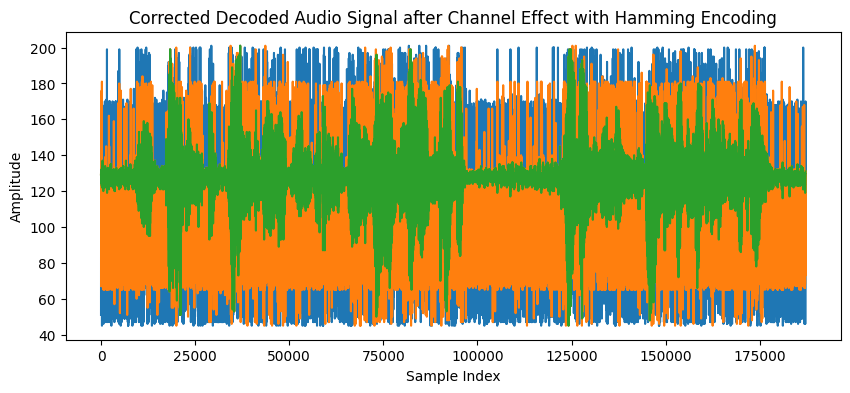

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(decoded_audio_signal)
plt.plot(decoded_audio_red)
plt.plot(audio_signal)

plt.title('Corrected Decoded Audio Signal after Channel Effect with Hamming Encoding')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

wavfile.write('decoded_audio_red.wav', fs,decoded_audio_red.astype(np.float32))